In [113]:
import os
import json
import pandas as pd  # 1.5.0

from rdkit import Chem  # 2023.03.3
from rdkit.Chem.Draw import IPythonConsole
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict
import statistics

from structure_functions import *

# Deactivate rdkit messages:
from rdkit import RDLogger   
RDLogger.DisableLog("rdApp.*")

DATA_DIRECTORY_PATH = os.path.join((os.path.split(os.getcwd())[0]), "data")

# 0. Load dataset

In [114]:
# import dataset:
df = pd.read_csv(os.path.join(DATA_DIRECTORY_PATH, "FIA49k.csv.gz"))
df.shape

# filter dataset:
df = df[df["mol_type"] == "fia44k"]

print(f"Compounds in Dataset: {len(df)}")

Compounds in Dataset: 44877


In [115]:
def draw_boxplots(vals, labels, xlabel = "", ylabel = "", title = "", size = None, save_as = None):
    if size is not None:
        plt.figure().set_figheight(size)
    plt.boxplot(vals, vert = False, labels = labels)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save_as is not None:
        plt.savefig(save_as)
    plt.show()

# 1. Analyze substructures of radius 1

### 1.1 Search for substructures

In [117]:
radius = 1

substructures = defaultdict(lambda: [[], 0.])

# write all substructures in list:
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = substructures[row["Compound"]]
    elem[1] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        elem[0].extend(getSubSmilesRadN(Chem.MolFromSmiles(smi), radius))
        substructures[row["Compound"]] = (getSubSmilesRadN(Chem.MolFromSmiles(smi), radius), row["fia_solv-PBEh3c"])

# save substructure_list:
with open("substructures.json", "w") as f:
    #json.dump(substructure_list, f)
    json.dump(substructures, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44877/44877 [01:19<00:00, 565.77it/s]


### 1.2 Draw substructures

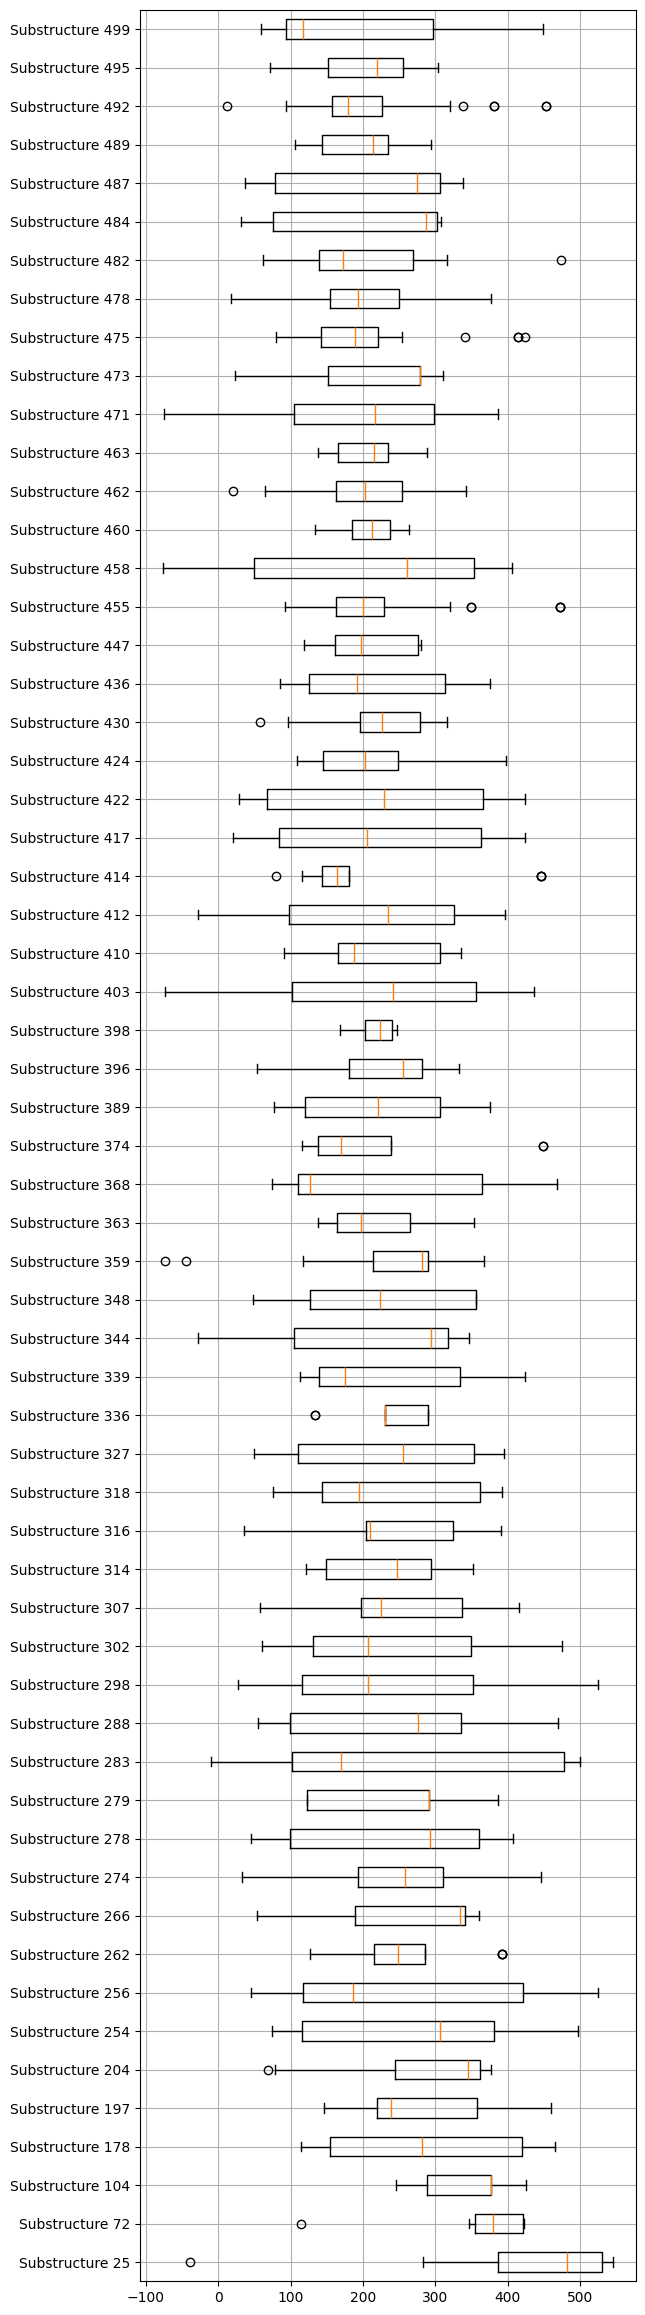

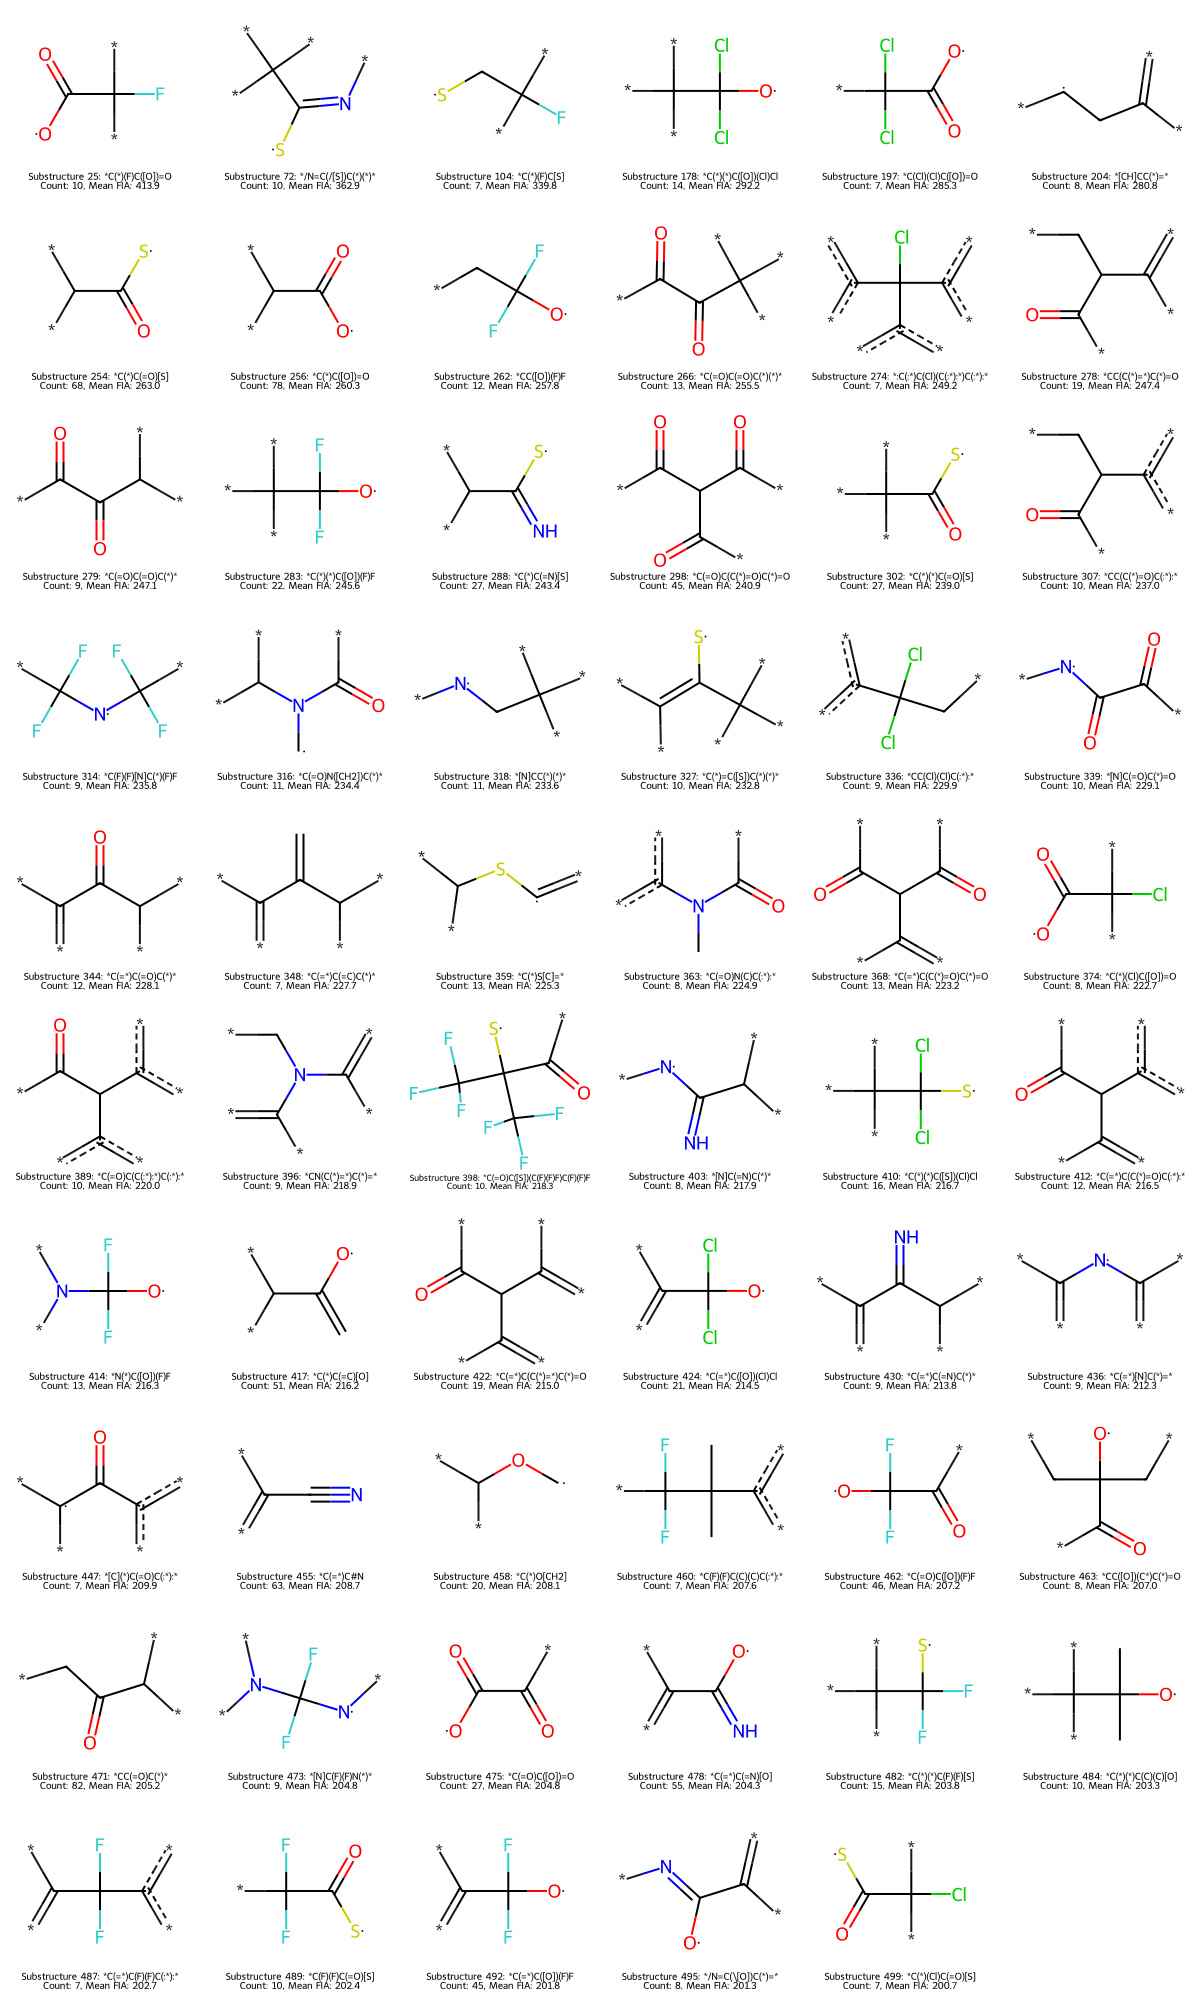

In [144]:
# load substructure_list:
with open("substructures.json", "r") as f:
    substructures_json = json.load(f)

# count substructures and append FIA values:
#substructure_counts = defaultdict(int)
#for i in substructure_list:
#    if i:
#        substructure_counts[i] += 1

# two-tuple of list of FIAs and substructure count
substructures = defaultdict(lambda: [[], 0])
for properties in substructures_json.values():
    # these are the substructures
    for substruct in properties[0]:
        substructures[substruct][0].append(properties[1])
        substructures[substruct][1] += 1

# sort substructure_counts by counts:
substructures = dict(sorted(substructures.items(), key=lambda item: item[1][1], reverse=True))
#substructure_counts = dict(sorted(substructure_counts.items(), key=lambda item: item[1], reverse=True))

# draw substructures:
smiles = list(substructures.keys())
counts = [str(x[1]) for x in substructures.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

substructures_highest_fia = dict(sorted(substructures.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 7

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(substructures_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}")
    legends.append(f"Substructure {i}: {k}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))

# 2. Analyze ring systems

### 2.1 Search for ring systems

In [121]:
ringsystems = defaultdict(lambda: [[], 0.])

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = ringsystems[row["Compound"]]
    elem[1] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        elem[0].extend(getRingSystemSmiles(Chem.MolFromSmiles(smi)))

with open("ringsystem.json", "w") as f:
    json.dump(ringsystems, f)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44877/44877 [00:14<00:00, 3196.60it/s]


### 2.2 Draw ringsystems

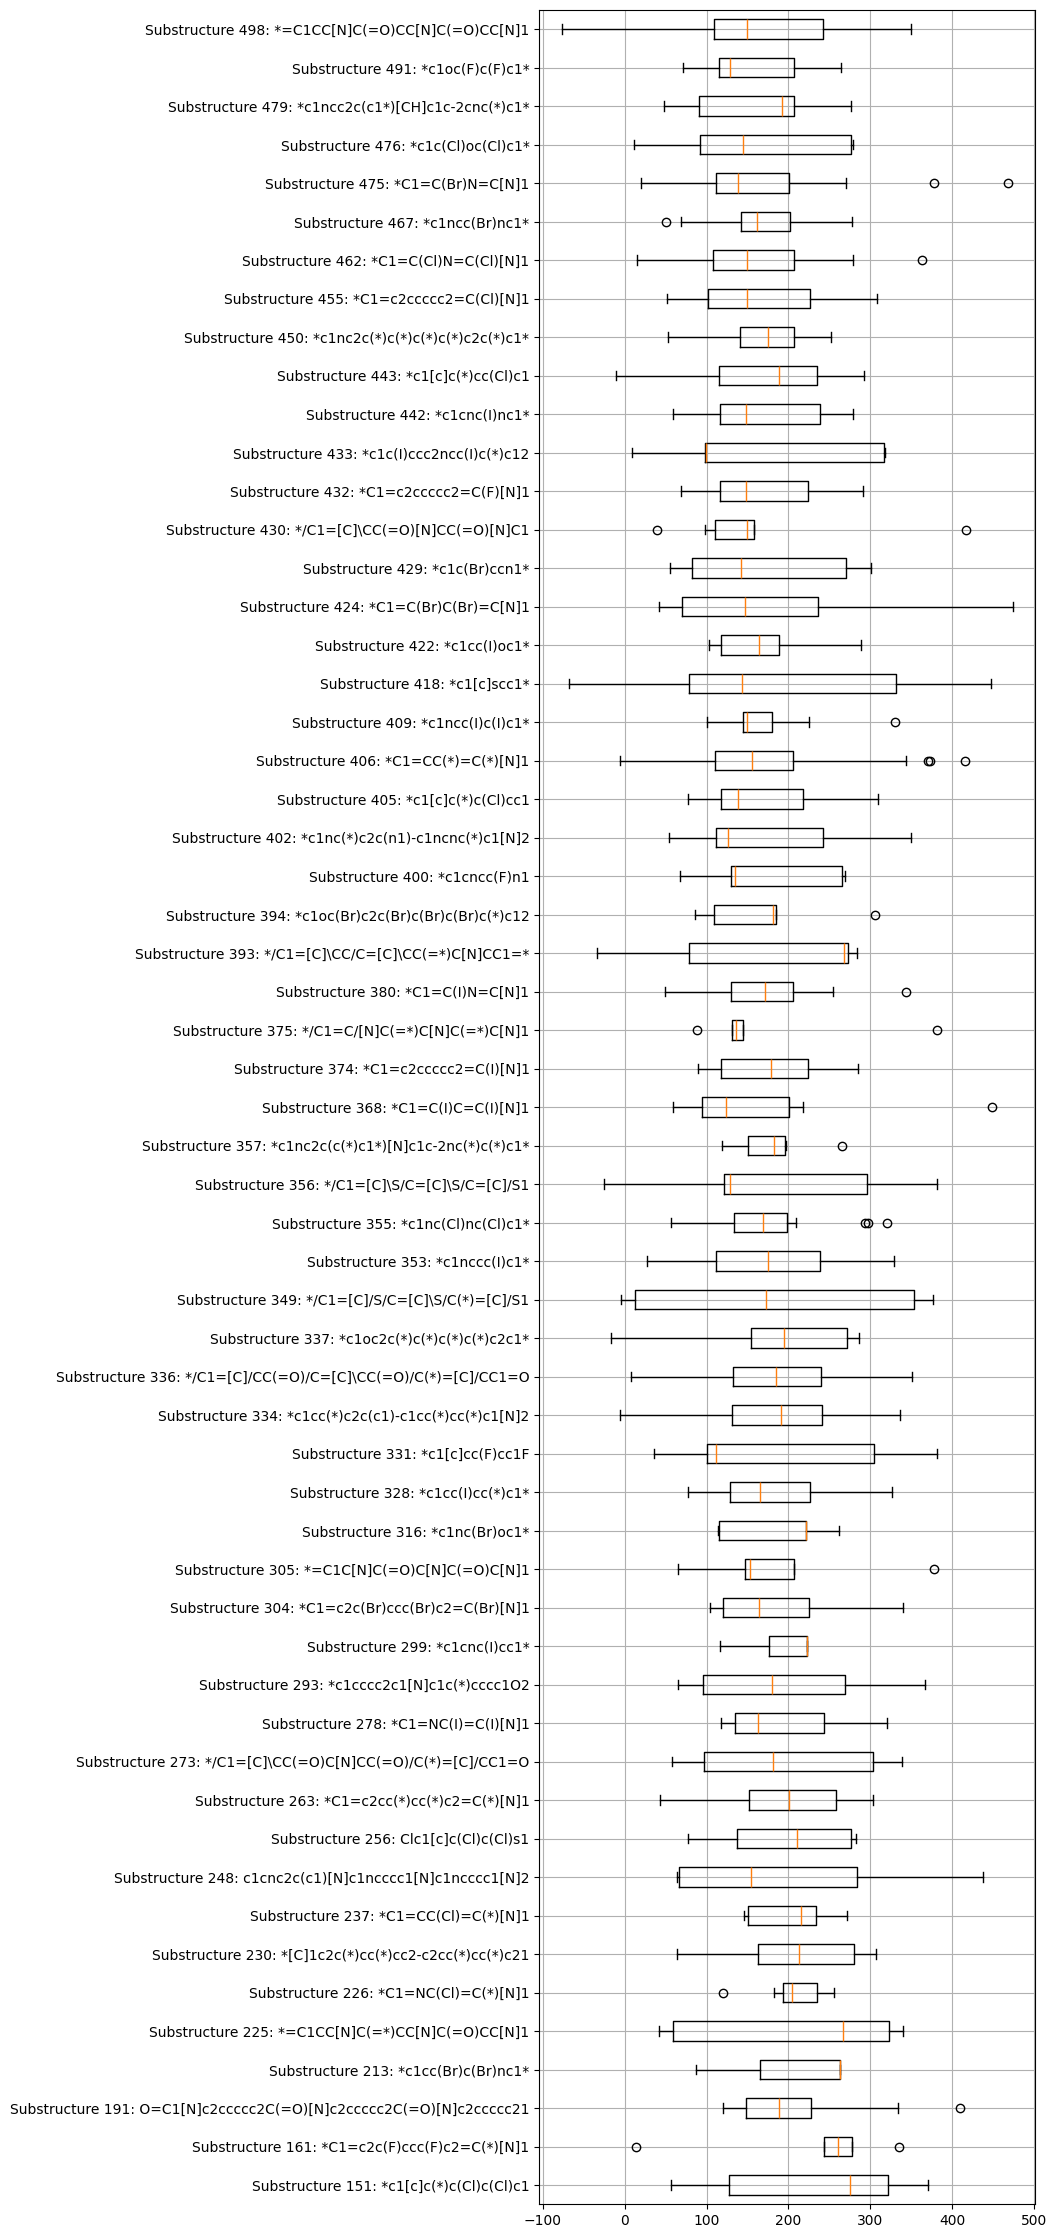

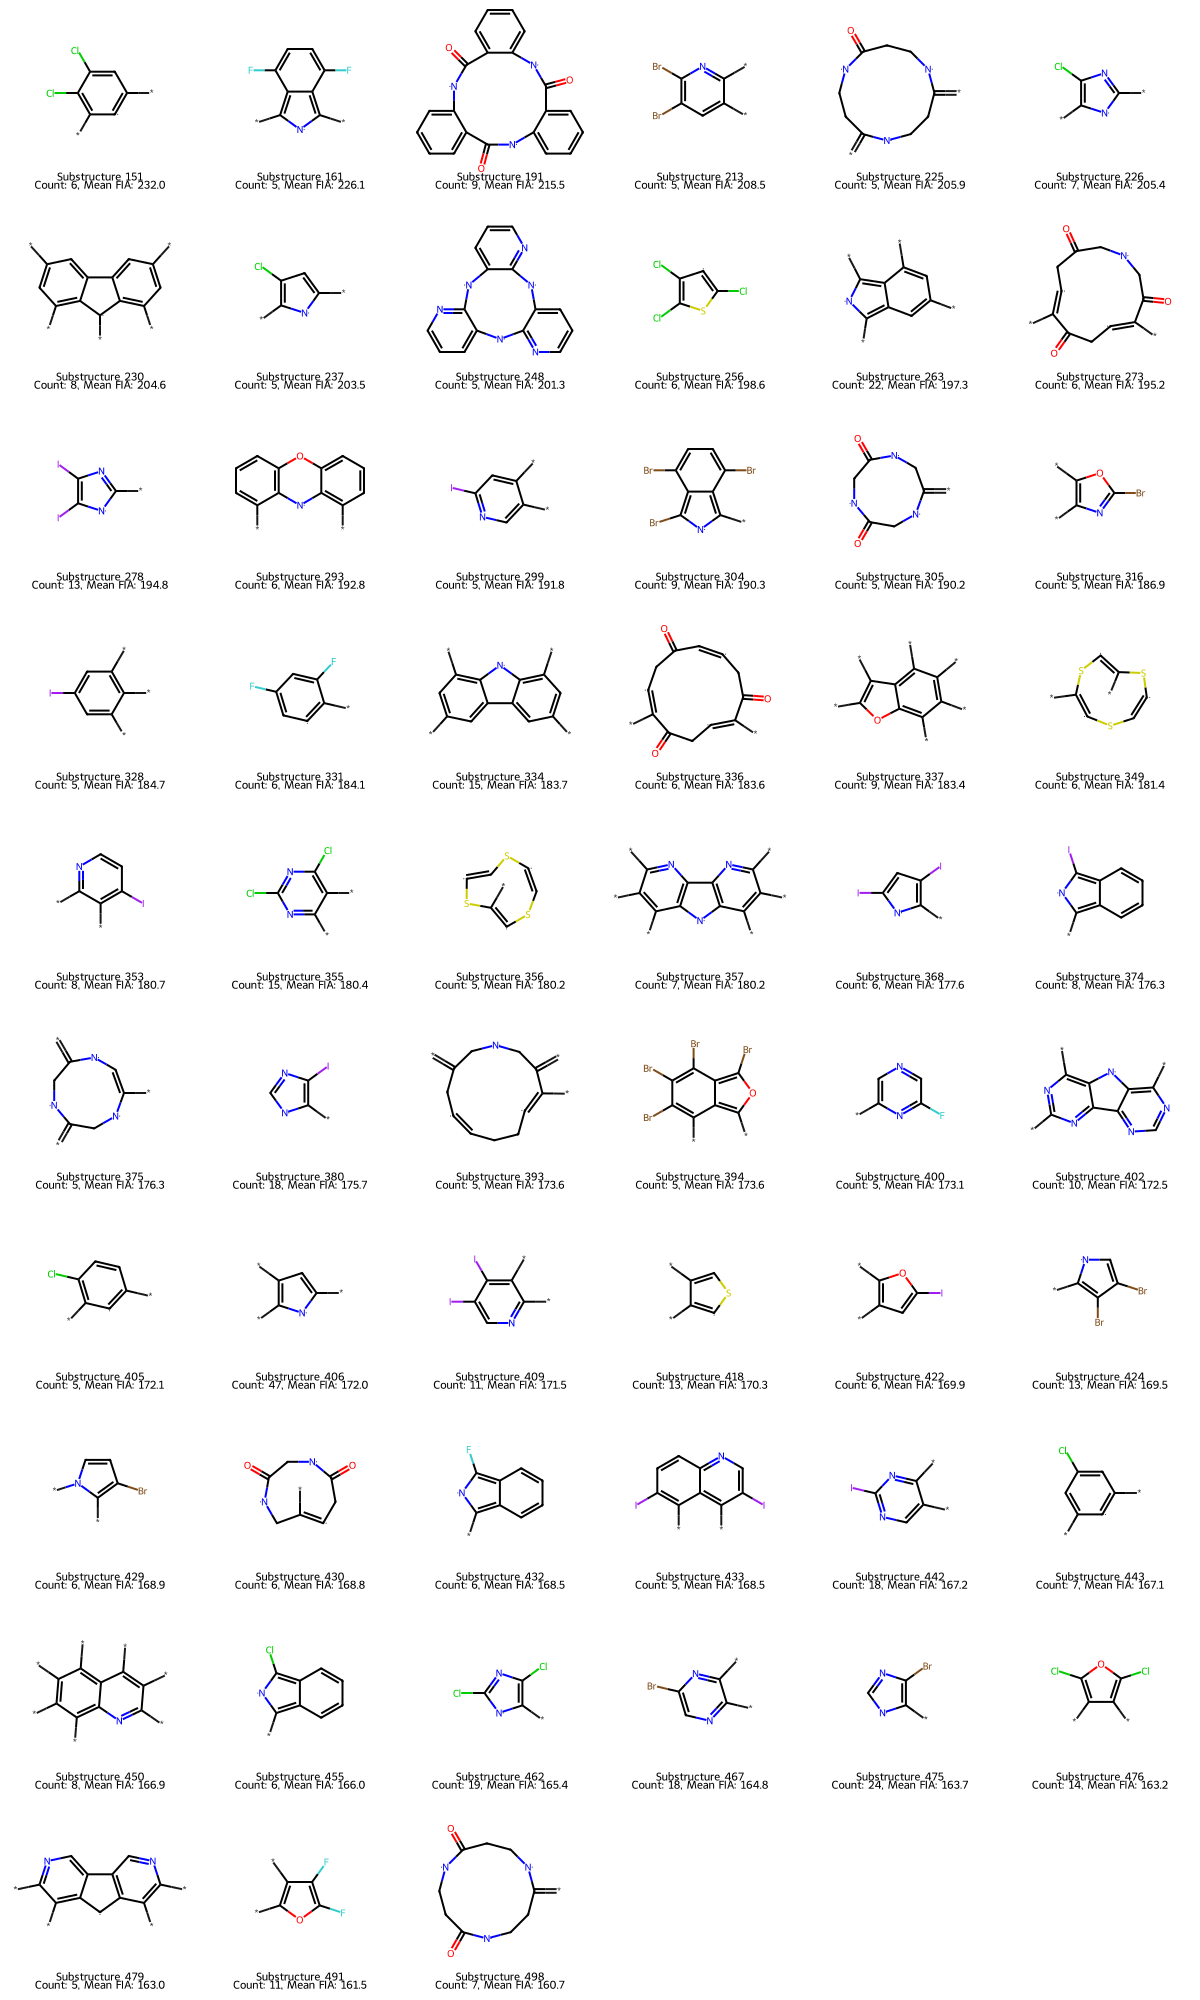

In [146]:
# load substructure_list:
with open("ringsystem.json", "r") as f:
    ringsystems_json = json.load(f)

# two-tuple of list of FIAs and ringsystem count
ringsystems = defaultdict(lambda: [[], 0])
for properties in ringsystems_json.values():
    # these are the substructures
    for substruct in properties[0]:
        ringsystems[substruct][0].append(properties[1])
        ringsystems[substruct][1] += 1

# sort substructure_counts by counts:
ringsystems = dict(sorted(ringsystems.items(), key=lambda item: item[1][1], reverse=True))

# draw substructures:
smiles = list(ringsystems.keys())
counts = [str(x[1]) for x in ringsystems.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

ringsystems_highest_fia = dict(sorted(ringsystems.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 5 

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(ringsystems_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}: {k}")
    legends.append(f"Substructure {i}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))